# Football Transfers Network Visualization

Every football season, clubs build up new teams, and fans watch the transfer market with new hopes for the upcoming season. Transfers play a crucial role in shaping teams' fortunes, making the transfer market a focal point of excitement and speculation. This project visualizes the network of football transfers among clubs in the top 5 European leagues: the Premier League, La Liga, Serie A, Bundesliga, and Ligue 1.


## Data Collection

In this section, we collect transfer data from a reliable source. The data includes detailed information about football transfers, such as player names, transfer fees, and the clubs involved.

Let's start by importing the necessary libraries.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import difflib
import time

These are the links that we are going to need:

In [2]:
# URLs for transfer data and league information

transfer_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/transfers/wettbewerb/GB1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Bundesliga":   "http://www.transfermarkt.es/bundesliga/transfers/wettbewerb/L1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Serie A":      "http://www.transfermarkt.es/serie-a/transfers/wettbewerb/IT1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "Ligue 1":      "http://www.transfermarkt.es/ligue-1/transfers/wettbewerb/FR1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                "La Liga":      "http://www.transfermarkt.es/primera-division/transfers/wettbewerb/ES1/plus/?saison_id=2023&s_w=&leihe=1&intern=0&intern=1",
                }


liga_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2023",
            "Bundesliga":   "http://www.transfermarkt.es/bundesliga/startseite/wettbewerb/L1/?saison_id=2023",
            "Serie A":      "http://www.transfermarkt.es/serie-a/startseite/wettbewerb/IT1/?saison_id=2023",
            "Ligue 1":      "http://www.transfermarkt.es/ligue-1/startseite/wettbewerb/FR1/?saison_id=2023",
            "La Liga":      "http://www.transfermarkt.es/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2023",
            }

Now we iterate over the the 5 leagues. First, we get all the teams of the league from the dictionary *liga_urls*. Then we get the transactions of each team and store them in a pandas DataFrame.

In [6]:
# DataFrame to store transfer data
df = pd.DataFrame(columns = ["target", "source", "cost", "player"])

# Collecting transfer data for each league
for liga in transfer_urls.keys():

    # Fetching the list of clubs for the league
    r = requests.get(liga_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    # Extracting club names
    for i in range(len(read_html_pandas_data)):
        try:
            teams_short = read_html_pandas_data[i]["Club.1"].to_list()
            teams_short.sort()

        except:
            pass
    
    # Delay to avoid overloading the server
    time.sleep(2)

    # Fetching transfer data for the league
    r = requests.get(transfer_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    soup = BeautifulSoup(r.text, "lxml")
    clubs =  soup.find_all("h2")

    clubs_list = []

    for club in clubs:
        try:
            club_name = difflib.get_close_matches(str(club.a.img).split('"')[1], 
                                                teams_short, 
                                                n=1 ,
                                                cutoff=0.45
                                                )[0]
            
            if club_name not in clubs_list:
                clubs_list.append(club_name)
        except:
            pass

    # Processing incoming and outgoing transfers for each club
    for i, club in enumerate(clubs_list):

        df_in = read_html_pandas_data[2*i +1]
        df_in.rename(columns={"Último club.1": "source", 
                              "Altas": "player", 
                              "Coste": "cost"}, 
                              inplace= True)
        df_in["target"] = club

        df_out = read_html_pandas_data[2*i +2]
        df_out.rename(columns={"Nuevo club.1": "target",  
                               "Bajas": "player", 
                               "Coste": "cost"}, 
                               inplace= True)
        df_out["source"] = club

        df = pd.concat([df,df_in[["target", "source", "cost", "player"]]])
        df = pd.concat([df,df_out[["target", "source", "cost", "player"]]])
        
# Displaying the collected data
df.head(10)

,target,source,cost,player
0,Arsenal,West Ham,"116,60 mill. €",Declan RiceD. Rice
1,Arsenal,Chelsea,"75,00 mill. €",Kai HavertzK. Havertz
2,Arsenal,Ajax,"40,00 mill. €",Jurrien TimberJ. Timber
3,Arsenal,Brentford,"Coste de cesión: 3,50 mill. €",David RayaD. Raya
4,Arsenal,Monza,Fin de cesión 30/06/2023,Pablo MaríP. Marí
5,Arsenal,Luton,Fin de cesión 31/05/2024,Albert Sambi LokongaA. Lokonga
6,Arsenal,Stade Reims,Fin de cesión 30/06/2023,Folarin BalogunF. Balogun
7,Arsenal,Niza,Fin de cesión 30/06/2023,Nicolas PépéN. Pépé
8,Arsenal,Fulham,Fin de cesión 30/06/2023,Cédric SoaresC. Soares
9,Arsenal,Marsella,Fin de cesión 30/06/2023,Nuno TavaresN. Tavares


Finally, we save the DataFrame to a .csv

In [7]:
df.to_csv("transfers_2023.csv", index= False)

## Data Cleaning

After collecting the data, it is essential to clean and process it to ensure accuracy and consistency. This includes removing duplicates, correcting errors, and formatting the data appropriately for analysis.

In [9]:
df = pd.read_csv("transfers_2023.csv")

df = df.drop_duplicates()

#Removing players that retire
df = df[df["target"] != "Retirado"]

#Removing the transfers of coming back of a loan, otherwise loans weight 2x
df = df[df["cost"].str[:13] != "Fin de cesión"]

#Removing players which stay without team
df = df[df["target"] != "Sin equipo"]
df = df[df["source"] != "Sin equipo"]

Once we have all the individual transfers in each row, we summarize the opperations between the clubs. For that we can aggreagate by counting them like follows:

In [10]:
df_transfer = df[["target", "source", "player"]].groupby(["target", "source"]).count().reset_index()
df_transfer.rename(columns = {"player": "value"}, inplace = True)

df_transfer.head(10)

,target,source,value
0,1.FC K'lautern,Colonia,1
1,1.FC K'lautern,Darmstadt 98,2
2,1.FC K'lautern,Eintracht,1
3,1.FC K'lautern,Unión Berlín,1
4,1.FC Magdeburg,Inter,1
5,1.FC Magdeburg,Niza,1
6,1.FC Nürnberg,Eintracht,2
7,1.FC Nürnberg,VfL Bochum,1
8,1860 München,Werder Bremen,1
9,A. Klagenfurt,Unión Berlín,1


Now the data is ready to be used for the network analysis.

## Network

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

After importing the necessary libraries, we can create a graph with the data we prepared.

In [12]:
# Creating a graph from the cleaned data
G = nx.from_pandas_edgelist(df_transfer,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph(),
                            )

# Displaying basic information about the graph
print(nx.info(G))

Graph with 766 nodes and 2119 edges


/tmp/ipykernel_11563/2993142541.py:10: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


### Visualization




Let's visualize the network. First we use Matplotlib

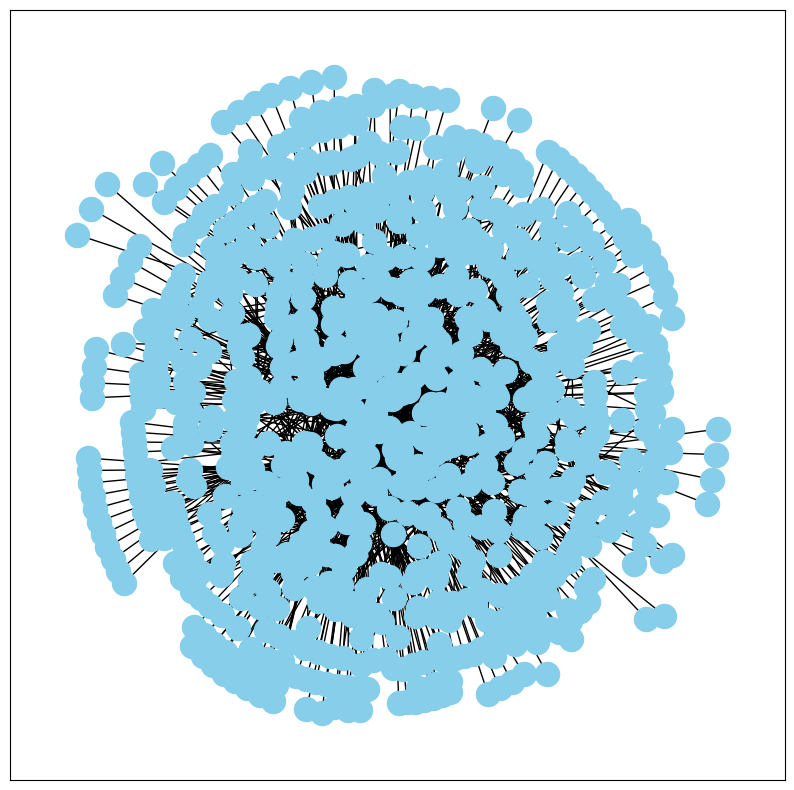

In [20]:
# Visualizing the network using Matplotlib

plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G)

node_degree = dict(G.degree)
nx.draw_networkx(G, 
                 with_labels = False, 
                 node_color = "skyblue", 
                 edge_cmap = "Blues", 
                 pos = pos, 
                 )

plt.show()

The above plot shows the network of transfers among clubs. The size of the nodes represents the degree centrality, indicating the number of transfers associated with each club.

But it isn't very useful... Let's do better

In [21]:
# Creating an interactive network visualization using PyVis
net = Network(notebook = False, width ="1000px", height = "720px", bgcolor = "#222222", font_color = "white")

# Calculating centrality metrics
node_degree = dict(G.degree)
centrality_dict = nx.degree_centrality(G)
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)

# Community detection using the Louvain method
communities = nx.community.louvain_communities(G)   
community_dict = {}
for group_id, community in enumerate(communities):
    for node in community:
        community_dict[node] = group_id

# Setting node attributes
nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, centrality_dict, "degree_centrality")
nx.set_node_attributes(G, closeness_dict, "closeness_centrality")
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")
nx.set_node_attributes(G, community_dict, "group")


# Adding nodes and edges to the PyVis network
net.repulsion()
net.from_nx(G)
net.show("html_network/transfer.html")

The interactive visualization created using PyVis allows for exploring the transfer network in more detail. Nodes can be clicked to view more information about each club, and the network can be zoomed and panned for better exploration. 

Enjoy!
